In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


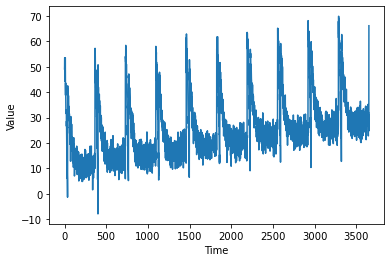

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 2s 20ms/step - loss: 20.3828 - mae: 20.8828
Epoch 2/100
94/94 [==============================] - 2s 18ms/step - loss: 20.3543 - mae: 20.8543
Epoch 3/100
94/94 [==============================] - 2s 17ms/step - loss: 20.3218 - mae: 20.8218
Epoch 4/100
94/94 [==============================] - 2s 17ms/step - loss: 20.2852 - mae: 20.7851
Epoch 5/100
94/94 [==============================] - 2s 17ms/step - loss: 20.2436 - mae: 20.7436
Epoch 6/100
94/94 [==============================] - 2s 22ms/step - loss: 20.1964 - mae: 20.6964
Epoch 7/100
94/94 [==============================] - 2s 23ms/step - loss: 20.1429 - mae: 20.6429
Epoch 8/100
94/94 [==============================] - 2s 23ms/step - loss: 20.0823 - mae: 20.5823
Epoch 9/100
94/94 [==============================] - 2s 22ms/step - loss: 20.0140 - mae: 20.5140
Epoch 10/100
94/94 [==============================] - 2s 22ms/step - loss: 19.9385 - mae: 20.4385
Epoch 11/100
94/94 [=========

94/94 [==============================] - 2s 22ms/step - loss: 3.0818 - mae: 3.5428
Epoch 86/100
94/94 [==============================] - 2s 22ms/step - loss: 3.0073 - mae: 3.4699
Epoch 87/100
94/94 [==============================] - 2s 22ms/step - loss: 3.0323 - mae: 3.4962
Epoch 88/100
94/94 [==============================] - 2s 22ms/step - loss: 2.9179 - mae: 3.3838
Epoch 89/100
94/94 [==============================] - 2s 21ms/step - loss: 3.2024 - mae: 3.6707
Epoch 90/100
94/94 [==============================] - 2s 22ms/step - loss: 3.0403 - mae: 3.5057
Epoch 91/100
94/94 [==============================] - 2s 22ms/step - loss: 3.0679 - mae: 3.5328
Epoch 92/100
94/94 [==============================] - 2s 21ms/step - loss: 3.1354 - mae: 3.6052
Epoch 93/100
94/94 [==============================] - 2s 21ms/step - loss: 2.9133 - mae: 3.3788
Epoch 94/100
94/94 [==============================] - 2s 21ms/step - loss: 2.9577 - mae: 3.4235
Epoch 95/100
94/94 [==============================] -

(1e-08, 0.0001, 0.0, 30.0)

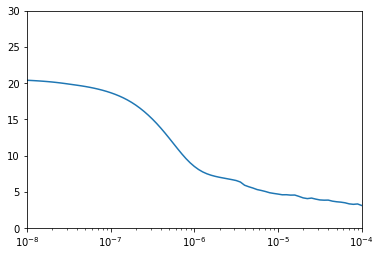

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 2s 21ms/step - loss: 263.1985 - mae: 10.1378
Epoch 2/500
94/94 [==============================] - 2s 23ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/500
94/94 [==============================] - 2s 21ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/500
94/94 [==============================] - 2s 22ms/step - loss: 31.9160 - mae: 3.9759
Epoch 5/500
94/94 [==============================] - 2s 22ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/500
94/94 [==============================] - 2s 22ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/500
94/94 [==============================] - 2s 22ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/500
94/94 [==============================] - 2s 22ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/500
94/94 [==============================] - 2s 24ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/500
94/94 [==============================] - 3s 27ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/500
94/94 [=================

94/94 [==============================] - 2s 23ms/step - loss: 21.5177 - mae: 3.1069
Epoch 86/500
94/94 [==============================] - 2s 23ms/step - loss: 22.5515 - mae: 3.2007
Epoch 87/500
94/94 [==============================] - 2s 24ms/step - loss: 24.2311 - mae: 3.4214
Epoch 88/500
94/94 [==============================] - 2s 23ms/step - loss: 21.6834 - mae: 3.1197
Epoch 89/500
94/94 [==============================] - 2s 24ms/step - loss: 23.2963 - mae: 3.2804
Epoch 90/500
94/94 [==============================] - 2s 23ms/step - loss: 22.5803 - mae: 3.2255
Epoch 91/500
94/94 [==============================] - 2s 24ms/step - loss: 22.9435 - mae: 3.2678
Epoch 92/500
94/94 [==============================] - 2s 23ms/step - loss: 22.9946 - mae: 3.2492
Epoch 93/500
94/94 [==============================] - 2s 24ms/step - loss: 21.8949 - mae: 3.1521
Epoch 94/500
94/94 [==============================] - 2s 23ms/step - loss: 22.7477 - mae: 3.2445
Epoch 95/500
94/94 [=======================

94/94 [==============================] - 2s 24ms/step - loss: 21.3695 - mae: 3.1401
Epoch 169/500
94/94 [==============================] - 2s 24ms/step - loss: 20.9859 - mae: 3.0777
Epoch 170/500
94/94 [==============================] - 2s 24ms/step - loss: 20.1615 - mae: 3.0056
Epoch 171/500
94/94 [==============================] - 2s 24ms/step - loss: 20.8315 - mae: 3.0901
Epoch 172/500
94/94 [==============================] - 2s 23ms/step - loss: 20.2492 - mae: 2.9919
Epoch 173/500
94/94 [==============================] - 2s 23ms/step - loss: 20.5532 - mae: 3.0338
Epoch 174/500
94/94 [==============================] - 2s 23ms/step - loss: 20.7731 - mae: 3.0725
Epoch 175/500
94/94 [==============================] - 2s 24ms/step - loss: 20.5776 - mae: 3.0553
Epoch 176/500
94/94 [==============================] - 2s 24ms/step - loss: 20.8999 - mae: 3.0842
Epoch 177/500
94/94 [==============================] - 2s 24ms/step - loss: 20.4238 - mae: 3.0239
Epoch 178/500
94/94 [=============

94/94 [==============================] - 2s 25ms/step - loss: 20.8288 - mae: 3.0829
Epoch 252/500
94/94 [==============================] - 2s 25ms/step - loss: 21.0175 - mae: 3.0600
Epoch 253/500
94/94 [==============================] - 2s 24ms/step - loss: 20.1876 - mae: 2.9927
Epoch 254/500
94/94 [==============================] - 2s 22ms/step - loss: 19.9836 - mae: 2.9835
Epoch 255/500
94/94 [==============================] - 2s 16ms/step - loss: 20.8168 - mae: 3.0846
Epoch 256/500
94/94 [==============================] - 1s 14ms/step - loss: 20.4073 - mae: 3.0273
Epoch 257/500
94/94 [==============================] - 1s 15ms/step - loss: 20.5301 - mae: 3.0393
Epoch 258/500
94/94 [==============================] - 1s 15ms/step - loss: 19.8521 - mae: 2.9595
Epoch 259/500
94/94 [==============================] - 1s 15ms/step - loss: 21.0645 - mae: 3.1025
Epoch 260/500
94/94 [==============================] - 1s 15ms/step - loss: 20.5715 - mae: 3.0398
Epoch 261/500
94/94 [=============

94/94 [==============================] - 1s 15ms/step - loss: 20.7681 - mae: 3.0693
Epoch 335/500
94/94 [==============================] - 1s 15ms/step - loss: 19.9867 - mae: 3.0137
Epoch 336/500
94/94 [==============================] - 1s 15ms/step - loss: 20.0798 - mae: 2.9979
Epoch 337/500
94/94 [==============================] - 1s 15ms/step - loss: 20.0707 - mae: 2.9655
Epoch 338/500
94/94 [==============================] - 1s 15ms/step - loss: 19.4712 - mae: 2.9085
Epoch 339/500
94/94 [==============================] - 1s 16ms/step - loss: 20.2753 - mae: 2.9986
Epoch 340/500
94/94 [==============================] - 1s 15ms/step - loss: 20.5241 - mae: 3.0326
Epoch 341/500
94/94 [==============================] - 1s 15ms/step - loss: 19.6770 - mae: 2.9451
Epoch 342/500
94/94 [==============================] - 1s 15ms/step - loss: 19.5318 - mae: 2.9364
Epoch 343/500
94/94 [==============================] - 1s 15ms/step - loss: 20.7584 - mae: 3.0912
Epoch 344/500
94/94 [=============

94/94 [==============================] - 1s 15ms/step - loss: 20.0838 - mae: 2.9991
Epoch 418/500
94/94 [==============================] - 1s 16ms/step - loss: 19.5072 - mae: 2.9231
Epoch 419/500
94/94 [==============================] - 1s 16ms/step - loss: 19.7957 - mae: 2.9576
Epoch 420/500
94/94 [==============================] - 1s 16ms/step - loss: 19.6350 - mae: 2.9662
Epoch 421/500
94/94 [==============================] - 3s 31ms/step - loss: 20.4850 - mae: 3.0387
Epoch 422/500
94/94 [==============================] - 2s 21ms/step - loss: 19.5877 - mae: 2.9423
Epoch 423/500
94/94 [==============================] - 2s 26ms/step - loss: 19.7165 - mae: 2.9603
Epoch 424/500
94/94 [==============================] - 3s 36ms/step - loss: 20.4419 - mae: 3.0556
Epoch 425/500
94/94 [==============================] - 3s 34ms/step - loss: 20.1487 - mae: 2.9971
Epoch 426/500
94/94 [==============================] - ETA: 0s - loss: 19.3797 - mae: 2.90 - 4s 41ms/step - loss: 19.3572 - mae: 2.9

94/94 [==============================] - 2s 23ms/step - loss: 19.3550 - mae: 2.9032


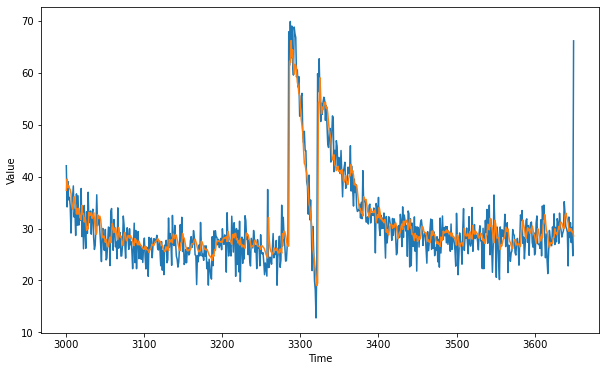

In [9]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9205348

<Figure size 432x288 with 0 Axes>

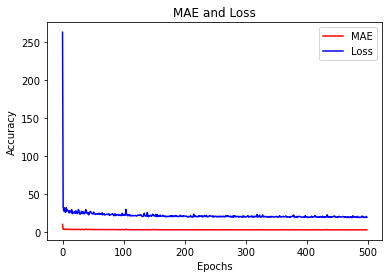

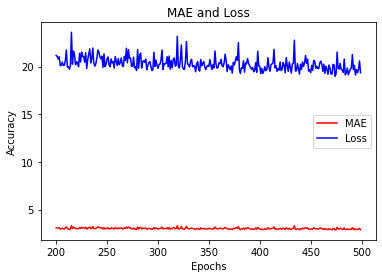

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()